In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


In [2]:
df = pd.read_csv("data/test_task_data.csv")


In [3]:
df.head()


,Transaction_id,customer_id,Date,Product,Gender,Device_Type,Country,State,State.1,City,Category,Customer_Login_type,Delivery_Type,Transaction_Result,Amount US$,Individual_Price_US$,Year_Month,Time,Quantity
0,40170,1348959766,14/11/2013,Hair Band,Female,Web,United States,New York,New York,New York City,Accessories,Member,one-day deliver,0,"6,910",576,13-Nov,22:35:51,12
1,33374,2213674919,05/11/2013,Hair Band,Female,Web,United States,California,California,Los Angles,Accessories,Member,one-day deliver,1,"1,699",100,13-Nov,06:44:41,17
2,14407,1809450308,01/10/2013,Hair Band,Female,Web,United States,Washington,Washington,Seattle,Accessories,Member,Normal Delivery,0,"4,998",217,13-Oct,00:41:24,23
3,15472,1691227134,04/10/2013,Hair Band,Female,Web,United States,Washington,Washington,Seattle,Accessories,Member,Normal Delivery,0,736,32,13-Oct,22:04:03,23
4,18709,2290737237,12/10/2013,Hair Band,Female,Web,United States,Washington,Washington,Seattle,Accessories,Member,Normal Delivery,1,"4,389",191,13-Oct,15:00:46,23


In [4]:
# State and State.1 the same
print(f"Are 'State' and 'State.1' the same? -> {(df["State"] == df["State.1"]).all()}")
df.drop(columns=["State.1"], inplace=True)

# There's only one country.
# There is only one city in each state, so we can leave out one of these features.
df.drop(columns=["Country", "City"], inplace=True)
# Later, we'll make one feature reflecting the passage of time.
df.drop(columns=["Year_Month"], inplace=True)


Are 'State' and 'State.1' the same? -> True


In [5]:
new_column_names = {
    "Transaction_id": "transaction_id",
    "Date": "date",
    "Product": "product",
    "Gender": "gender",
    "Device_Type": "device_type",
    "State": "state",
    "Category": "category",
    "Customer_Login_type": "customer_login_type",
    "Delivery_Type": "delivery_type",
    "Transaction_Result": "transaction_result",
    "Amount US$": "amount_us",
    "Individual_Price_US$": "individual_price_us",
    "Time": "time",
    "Quantity": "quantity",
}
df.rename(columns=new_column_names, inplace=True)


In [6]:
df.shape


(65535, 15)

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   transaction_id       65535 non-null  int64 
 1   customer_id          65535 non-null  int64 
 2   date                 65535 non-null  object
 3   product              65535 non-null  object
 4   gender               65535 non-null  object
 5   device_type          65535 non-null  object
 6   state                65535 non-null  object
 7   category             65535 non-null  object
 8   customer_login_type  65535 non-null  object
 9   delivery_type        65535 non-null  object
 10  transaction_result   65535 non-null  int64 
 11  amount_us            65534 non-null  object
 12  individual_price_us  65535 non-null  object
 13  time                 65535 non-null  object
 14  quantity             65535 non-null  int64 
dtypes: int64(4), object(11)
memory usage: 7.5+ MB


In [8]:
df.isnull().sum()


transaction_id         0
customer_id            0
date                   0
product                0
gender                 0
device_type            0
state                  0
category               0
customer_login_type    0
delivery_type          0
transaction_result     0
amount_us              1
individual_price_us    0
time                   0
quantity               0
dtype: int64

In [9]:
df["amount_us"] = df["amount_us"].str.replace(",", "")
df["amount_us"] = df["amount_us"].fillna(0)
df["amount_us"] = df["amount_us"].astype(int)


In [10]:
def replace_value(row):
    if row["individual_price_us"] == "#VALUE!":
        return row["amount_us"] / row["quantity"]
    else:
        return row["individual_price_us"]


df["individual_price_us"] = df["individual_price_us"].str.replace(",", "")
df["individual_price_us"] = df.apply(replace_value, axis=1)
df["individual_price_us"] = df["individual_price_us"].astype(int)


In [11]:
df["date_time_str"] = df["date"] + " " + df["time"]
df["datetime"] = pd.to_datetime(df["date_time_str"], format="%d/%m/%Y %H:%M:%S")
df.drop(columns=["date", "time", "date_time_str"], inplace=True)


In [12]:
# Since this is a time series, it is important to sort the data by time.
df = df.sort_values(by="datetime")


In [13]:
df.describe()


,transaction_id,customer_id,transaction_result,amount_us,individual_price_us,quantity,datetime
count,65535.000000,6.553500e+04,65535.000000,65535.000000,65535.000000,65535.000000,65535
mean,43933.318349,1.729511e+09,0.867353,4585.003433,276.671183,17.154299,2013-11-15 20:46:37.262119424
min,10001.000000,1.152933e+09,0.000000,0.000000,0.000000,12.000000,2013-09-20 00:04:07
25%,26384.500000,1.439080e+09,1.000000,648.000000,39.000000,15.000000,2013-10-25 15:47:51
50%,42768.000000,1.726960e+09,1.000000,1999.000000,116.000000,17.000000,2013-11-18 06:17:10
75%,59151.500000,2.020097e+09,1.000000,4571.000000,272.000000,20.000000,2013-12-06 22:11:32
max,93437.000000,2.305789e+09,1.000000,894869.000000,74572.000000,23.000000,2014-01-13 23:55:41
std,20980.667643,3.337308e+08,0.339195,13779.852991,872.399237,3.270824,NaN


In [14]:
df.duplicated().sum()


np.int64(0)

In [15]:
df.nunique()


transaction_id         65535
customer_id            64999
product                   12
gender                     2
device_type                2
state                      3
category                   8
customer_login_type        4
delivery_type              2
transaction_result         2
amount_us              11309
individual_price_us     2541
quantity                  12
datetime               65262
dtype: int64

### Nominal features

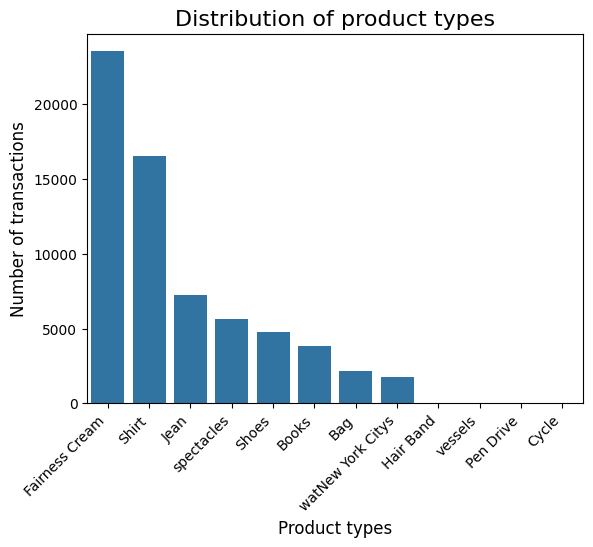

In [16]:
sns.countplot(data=df, x="product", order=df["product"].value_counts().index)

plt.title("Distribution of product types", fontsize=16)
plt.xlabel("Product types", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()


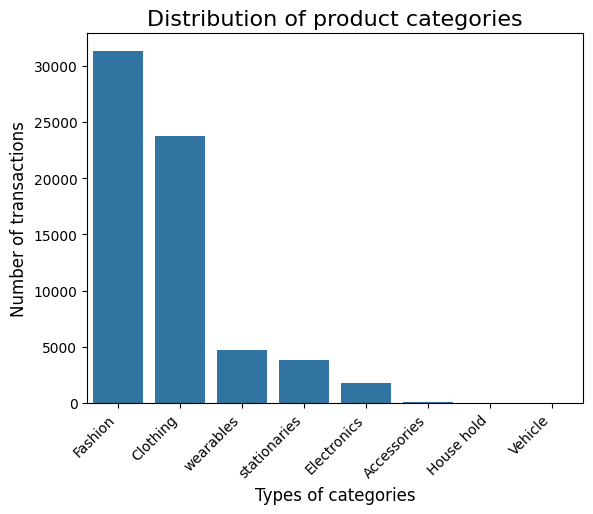

In [17]:
sns.countplot(data=df, x="category", order=df["category"].value_counts().index)

plt.title("Distribution of product categories", fontsize=16)
plt.xlabel("Types of categories", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()


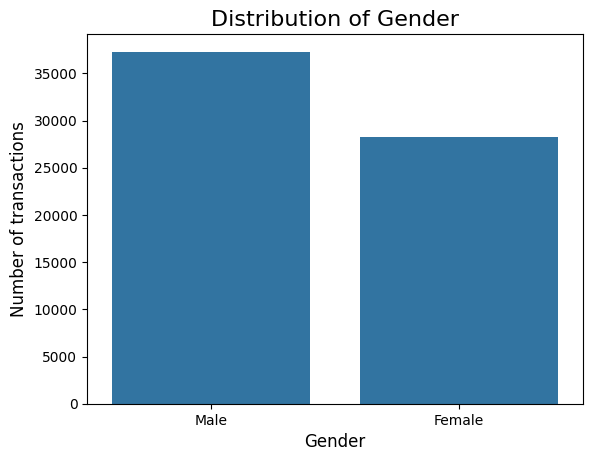

In [18]:
# man is 56.9%
# female is 43.09%
sns.countplot(data=df, x="gender", order=df["gender"].value_counts().index)

plt.title("Distribution of Gender", fontsize=16)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


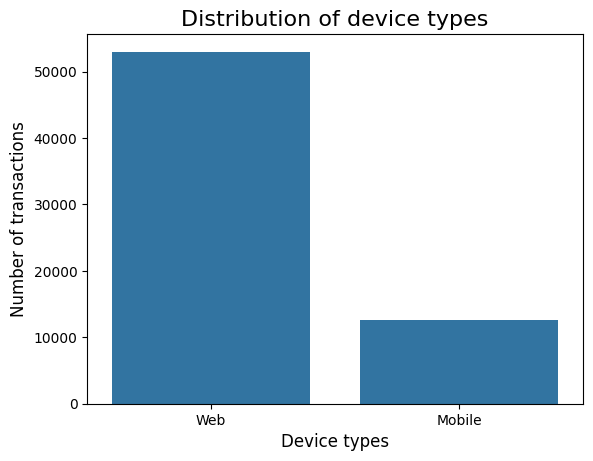

In [19]:
# Web is 80.1%
# Mobile is 19.1%
sns.countplot(data=df, x="device_type", order=df["device_type"].value_counts().index)

plt.title("Distribution of device types", fontsize=16)
plt.xlabel("Device types", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


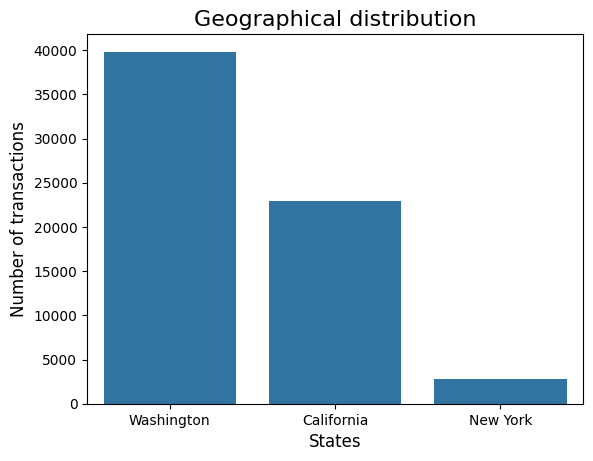

In [20]:
# New York is 4.2%
# California is 34.9%
# Washington is 60.7%
sns.countplot(data=df, x="state", order=df["state"].value_counts().index)

plt.title("Geographical distribution", fontsize=16)
plt.xlabel("States", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


### Ordinal features

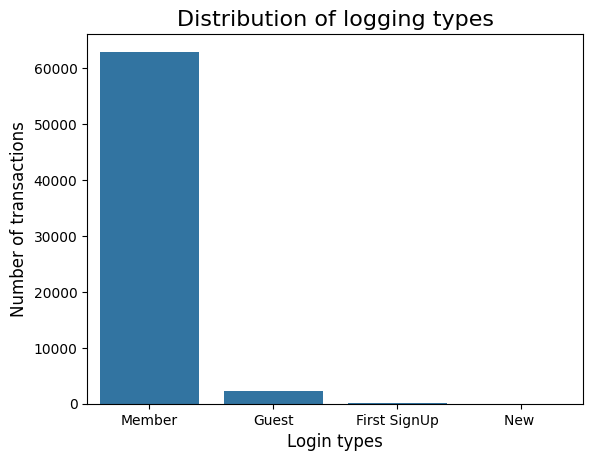

In [21]:
# Member is 96.1%
# Guest is 3.5%
# New is 0%
# First SignUp is 0.2%
sns.countplot(
    data=df,
    x="customer_login_type",
    order=df["customer_login_type"].value_counts().index,
)
plt.title("Distribution of logging types", fontsize=16)
plt.xlabel("Login types", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [22]:
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month_name()


In [23]:
monthly_transactions = (
    df.groupby(["year", "month"]).size().reset_index(name="transaction_count")
)
monthly_transactions = monthly_transactions.sort_values("month", ascending=False)
monthly_transactions = monthly_transactions.sort_values("year")


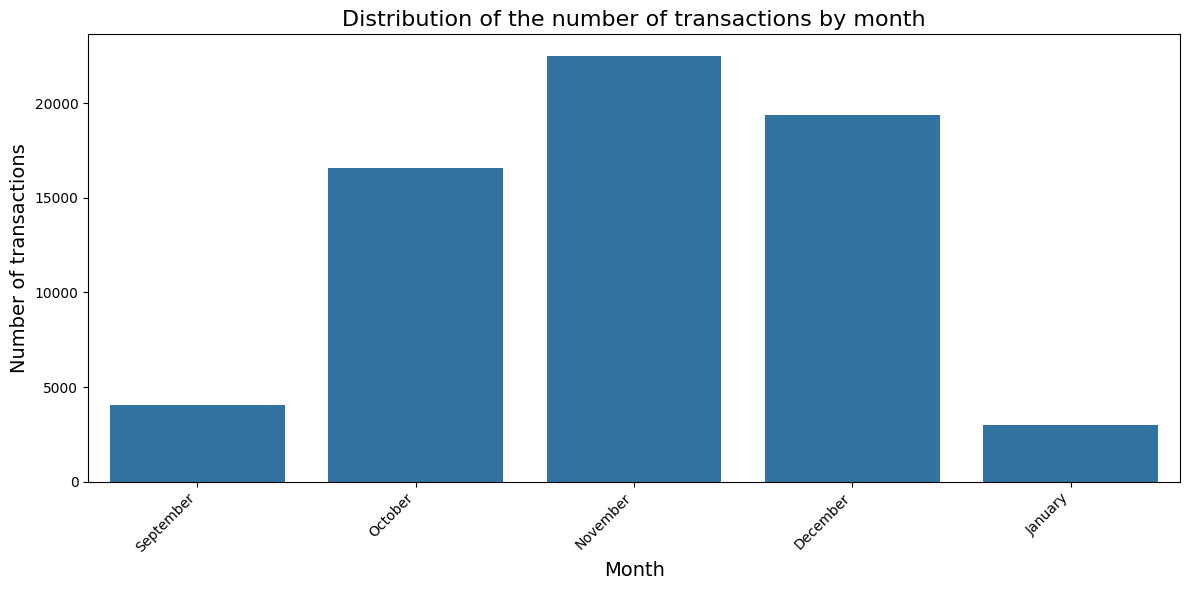

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x="month", y="transaction_count", data=monthly_transactions
)

plt.xticks(rotation=45, ha="right")
plt.title("Distribution of the number of transactions by month", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of transactions", fontsize=14)
plt.tight_layout()
plt.show()


#### I decided to remove the gender feature because a large number of users with the same customer_id have different genders in different transactions.

In [25]:
df.drop(columns=["gender"], inplace=True)


### Convert to numeric representation

In [26]:
# one-hot encoding
df["device_type"] = df["device_type"].map({"Web": 0, "Mobile": 1})
df["delivery_type"] = df["delivery_type"].map({"Normal Delivery": 0, "one-day deliver": 1})


### Feature engineering (before splitting)

In [27]:
# Days after last order
df["days_since_last_order"] = df.groupby("customer_id")["datetime"].diff().dt.days
df["days_since_last_order"] = df["days_since_last_order"].fillna(0)


In [28]:
df["is_working_time"] = df["datetime"].dt.hour.apply(
    lambda hour: 1 if 9 <= hour < 18 else 0
)
df["is_weekend"] = (df["datetime"].dt.dayofweek >= 5).astype(int)
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year


### Train | Val | Test split

In [29]:
df["target"] = 0
for i, row in df.iterrows():
    transaction_date = row["datetime"]
    customer_id = row["customer_id"]
    future_transactions: pd.DataFrame = df[
        (df["customer_id"] == customer_id)
        & (df["datetime"] > transaction_date)
        & (df["datetime"] <= transaction_date + timedelta(days=60))
    ]
    if not future_transactions.empty:
        df.loc[i, "target"] = 1


In [30]:
current_datetime = df["datetime"].max()
test_end = current_datetime - pd.DateOffset(months=2)
val_end = test_end - pd.DateOffset(weeks=1)
train_end = val_end - pd.DateOffset(weeks=1)

train: pd.DataFrame = df[df["datetime"] < train_end].copy()
val: pd.DataFrame = df[(df["datetime"] >= train_end) & (df["datetime"] < val_end)].copy()
test: pd.DataFrame = df[(df["datetime"] >= val_end) & (df["datetime"] < test_end)].copy()


In [31]:
print(f"train size = {train.size}. It is {round(train.size/df.size, 2)} from full set.")
print(f"val size = {val.size}. It is {round(val.size/df.size, 2)} from full set.")
print(f"test size = {test.size}. It is {round(test.size/df.size, 2)} from full set.")


train size = 377568. It is 0.3 from full set.
val size = 84854. It is 0.07 from full set.
test size = 100605. It is 0.08 from full set.


### Target Encoding (after splitting)

In [32]:
def target_encoding(
    column: str,
    new_column_name: str,
    train: pd.DataFrame = train,
    val: pd.DataFrame = val,
    test: pd.DataFrame = test,
    target_name: str = "target",
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    category_means = train.groupby(column)[target_name].mean()
    global_mean = train[target_name].mean()
    train[new_column_name] = train[column].map(category_means)
    val[new_column_name] = val[column].map(category_means).fillna(global_mean)
    test[new_column_name] = (
        test[column].map(category_means).fillna(global_mean)
    )

    train.drop(columns=column, inplace=True)
    val.drop(columns=column, inplace=True)
    test.drop(columns=column, inplace=True)

    return train, val, test


train, val, test = target_encoding("product", "product_encoded")
train, val, test = target_encoding("state", "state_encoded")
train, val, test = target_encoding("category", "category_encoded")
train, val, test = target_encoding("customer_login_type", "customer_login_type_encoded")


### Feature engineering (after splitting)

In [33]:
train["average_days_between_orders"] = train.groupby("customer_id")[
    "days_since_last_order"
].transform("mean")
aggs = train.groupby("customer_id")["days_since_last_order"].agg("mean").to_dict()
val["average_days_between_orders"] = val["customer_id"].map(aggs).fillna(0)
test["average_days_between_orders"] = test["customer_id"].map(aggs).fillna(0)


In [34]:
def customer_behavior(
    transform_column: str,
    new_column_name: str,
    func: str,
    groupby_column: str = "customer_id",
    train: pd.DataFrame = train,
    val: pd.DataFrame = val,
    test: pd.DataFrame = test
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    if func == 'count':
        train[new_column_name] = train.groupby(groupby_column)[transform_column].transform('count')
    elif func == 'mean':
        train[new_column_name] = train.groupby(groupby_column)[transform_column].transform('mean')

    aggs = train.groupby(groupby_column)[transform_column].agg(func).to_dict()
    val[new_column_name] = val[groupby_column].map(aggs).fillna(0)
    test[new_column_name] = test[groupby_column].map(aggs).fillna(0)

    return train, val, test

train, val, test = customer_behavior("transaction_id", "customer_num_of_transactions", "count")
train, val, test = customer_behavior("amount_us", "customer_avg_bill", "mean")
train, val, test = customer_behavior("individual_price_us", "customer_avg_price_per_item", "mean")
train, val, test = customer_behavior("quantity", "customer_avg_quantity", "mean")


#### We've already extracted the features we need from the timestamp.

In [35]:
train.drop(columns=["datetime"], inplace=True)
val.drop(columns=["datetime"], inplace=True)
test.drop(columns=["datetime"], inplace=True)


In [36]:
def split_features_target(df: pd.DataFrame, target: str = "target"):
    X = df.drop(target, axis=1)
    y = df[target]
    return X, y


x_train, y_train = split_features_target(train)
x_val, y_val = split_features_target(val)
x_test, y_test = split_features_target(test)


#### The distribution of the target feature across samples appeared to be similar. 

In [37]:
print(f"train target mean: {round(y_train.mean(), 2)}")
print(f"val target mean: {round(y_val.mean(), 2)}")
print(f"test target mean: {round(y_test.mean(), 2)}")


train target mean: 0.01
val target mean: 0.01
test target mean: 0.01


### Modeling

In [94]:
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

rf_grid_search = GridSearchCV(
    estimator=rf_model, param_grid=rf_param_grid, scoring="roc_auc", cv=5, n_jobs=-1
)
rf_grid_search.fit(x_train, y_train)

print("Best parameters for Random Forest::", rf_grid_search.best_params_)
best_rf_model = rf_grid_search.best_estimator_

y_val_pred_rf = best_rf_model.predict_proba(x_val)[:, 1]
val_auc_rf = roc_auc_score(y_val, y_val_pred_rf)
val_logloss_rf = log_loss(y_val, y_val_pred_rf)
print("ROC-AUC for Random Forest on validation sampling:", val_auc_rf)
print("LogLoss for Random Forest on validation sampling:", val_logloss_rf)


Best parameters for Random Forest:: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
ROC-AUC for Random Forest on validation sampling: 0.739598504645379
LogLoss for Random Forest on validation sampling: 0.15838154501170248


In [95]:
xgb_model = XGBClassifier(
    random_state=42, eval_metric="logloss"
)

xgb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
}

xgb_grid_search = GridSearchCV(
    estimator=xgb_model, param_grid=xgb_param_grid, scoring="roc_auc", cv=5, n_jobs=-1
)
xgb_grid_search.fit(x_train, y_train)

print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
best_xgb_model = xgb_grid_search.best_estimator_

y_val_pred_xgb = best_xgb_model.predict_proba(x_val)[:, 1]
val_auc_xgb = roc_auc_score(y_val, y_val_pred_xgb)
val_logloss_xgb = log_loss(y_val, y_val_pred_xgb)
print("ROC-AUC for XGBoost on validation sampling:", val_auc_xgb)
print("LogLoss for XGBoost on validation sampling:", val_logloss_xgb)


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
ROC-AUC for XGBoost on validation sampling: 0.6937125701276099
LogLoss for XGBoost on validation sampling: 0.04340321845894893


In [98]:
x_val["y_true"] = y_val
x_val["y_pred_rf"] = y_val_pred_rf
x_val["y_pred_xgb"] = y_val_pred_xgb


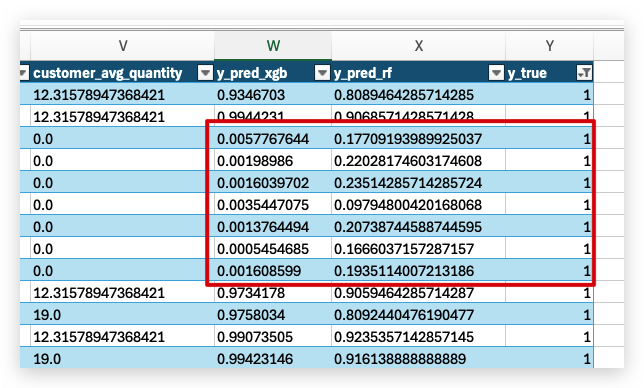

In [101]:
Image("images/Xnip2025-01-29_14-23-45.jpg")


I like the fact that a random forest has a much higher probability than XGBoost for the majority of incorrectly guessed transactions.